In [1]:
! wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz

--2022-01-01 13:54:53--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘UCSD_Anomaly_Dataset.tar.gz’

UCSD_Anomaly_Datase 100%[===================>] 706.01M  18.4MB/s    in 44s     

2022-01-01 13:55:38 (16.0 MB/s) - ‘UCSD_Anomaly_Dataset.tar.gz’ saved [740306953/740306953]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from os import mkdir

mkdir("/content/Dataset/")
mkdir("/content/Dataset/UCSD/")

In [32]:
!tar -xzf "/content/UCSD_Anomaly_Dataset.tar.gz" -C "/content/Dataset/UCSD" 

In [33]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [34]:
from os import listdir, mkdir, remove
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [4]:
class ModelConfig:
    TRAIN_DATASET_PATH_1 ="/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
    TRAIN_DATASET_PATH_2 ="/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train"
    TEST_DATASET_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test"
    SINGLE_TEST_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test005"
    BATCH_SIZE = 1
    EPOCHS = 10
    MODEL_WEIGHTS_DIRECTORY = "/content/drive/MyDrive/Dataset/UCSD/Train"
    COMBINE_MODEL_PATH = "GAN_combine_model.hdf5"
    GENERATOR_MODEL_PATH = "GAN_generator_model.hdf5"
    DISCRIMINATOR_MODEL_PATH = "GAN_discriminator_model.hdf5"
    AUTOENCODER_MODEL_PATH = "ucsd_p2_autoencoder_model.hdf5"
    SEQUENCE_SIZE = 10
    H = 256
    W = 256
    C = 1
    STRIDE = range(1, 2)
    TRAIN_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Train/npys"
    TEST_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Test/npys"



In [5]:
import shutil
 
# shutil.rmtree("/content/drive/MyDrive/Dataset/UCSD/Train/")
# shutil.rmtree("/content/drive/MyDrive/Dataset/UCSD/Test/")

In [6]:
# shutil.rmtree("/content/Dataset/UCSD/Train/")
# shutil.rmtree("/content/Dataset/UCSD/Test/")

In [160]:
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Train/")
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Train/npys/")

In [161]:
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Test/")
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Test/npys/")

In [162]:
mkdir("/content/Dataset/UCSD/Train/")
mkdir("/content/Dataset/UCSD/Train/npys/")

mkdir("/content/Dataset/UCSD/Test/")
mkdir("/content/Dataset/UCSD/Test/npys/")


FileExistsError: ignored

In [163]:
def save_4D_sample_npz(sample, directory, index):
    file_name = "smaple_{}.npz".format(index)
    file_path = join(directory, file_name)
    np.savez(file_path, sample)
    return file_name

In [164]:
def load_npz_4D_sample(directory, file_name):
    file_path = join(directory, file_name)
    dict_data = np.load(file_path)
    data = dict_data['arr_0']
    return data

In [165]:
def save_samples_npz(sample, npz_files_directory, num_sample):
    file_name = save_4D_sample_npz(sample, npz_files_directory, num_sample)
    return file_name

In [166]:
def get_clips_by_stride(frames_list, stride, index, npz_files_directory,
                        sequence_size=ModelConfig.SEQUENCE_SIZE):
    segments = []
    sz = len(frames_list)
    frames = np.zeros(shape=(sequence_size, ModelConfig.H, ModelConfig.W, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            frames[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                segments.append(save_samples_npz(frames, npz_files_directory, index))
                cnt = 0
                index += 1
    return np.array(segments), index

In [167]:
def get_sample_tiff_files(directory_path):
    clip = []
    all_frames = []
    for c in sorted(listdir(directory_path)):
        img_path = join(directory_path, c).replace("\\", '/')
        if str(img_path)[-3:] == "tif":
            img = Image.open(img_path).resize((ModelConfig.H, ModelConfig.W))
            img = np.array(img, dtype=np.float32) / 255.0
            all_frames.append(img)

    
    num_segments = 0
    for st in ModelConfig.STRIDE:
        segments, last_index = get_clips_by_stride(frames_list=all_frames,
                                                   stride=st,
                                                   index=num_segments,
                                                   npz_files_directory=ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY,
                                                   sequence_size=ModelConfig.SEQUENCE_SIZE)
        num_segments+=last_index
        clip.extend(segments)

    return clip

In [168]:
def get_dataset(dataset_directory):
    sample_name_list = []
    sample_directory_path_list = []
    for f in sorted(listdir(dataset_directory)):
        directory_path = join(dataset_directory, f).replace("\\", '/')
        if isdir(directory_path):
            sample_name_list.append(f)
            sample_directory_path_list.append(directory_path)
    return sample_name_list, sample_directory_path_list


In [169]:
sample_name_list, sample_directory_path_list = get_dataset(ModelConfig.TRAIN_DATASET_PATH_2)

In [170]:
train_df = pd.DataFrame(list(zip(sample_name_list, sample_directory_path_list)),
                        columns=['file_name', 'file_path'])


In [171]:
train_df


,file_name,file_path
0,Train001,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
1,Train002,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
2,Train003,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
3,Train004,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
4,Train005,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
5,Train006,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
6,Train007,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
7,Train008,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
8,Train009,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
9,Train010,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...


In [172]:
sample_name_list, sample_directory_path_list = get_dataset(ModelConfig.TEST_DATASET_PATH)


In [173]:
test_df = pd.DataFrame(list(zip(sample_name_list, sample_directory_path_list)),
                        columns=['file_name', 'file_path'])


In [174]:
def clear_npz_directory(directory_path):
    for f in listdir(directory_path):
        remove(join(directory_path, f))
        
clear_npz_directory(ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY)     

In [175]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, dataset_df, X_col, shuffle=True, data_augmentation=True):
        self.batch_size = 1
        self.dataset_df = dataset_df
        self.X_col = X_col
        self.shuffle = shuffle
        self.X_path = self.dataset_df[self.X_col]
        self.print_stats()
        return None    
    
    def print_stats(self):
        self.n_files = len(self.X_path)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        print("Number of sampels: ", len(self.indexes))
    
    def __len__(self):
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        index = self.indexes[index]
        batch_path = self.X_path[[index]]        
        batch_x = self.data_generation(batch_path)               
        return batch_x
    
    def get_mini_batch(self, index):
        return self.__getitem__(index)

    def on_epoch_end(self):
        # shuffle the data at each end of epoch
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        batch_x = [self.load_data(x) for x in batch_path]

        batch_x = np.array(batch_x)
        return batch_x
    
    def load_data(self, path):
        #print(path)
        segments = get_sample_tiff_files(path)
        return segments

In [176]:

train_gen = CustomDataGen(train_df,
                           X_col="file_path",
                           shuffle=True)


Number of sampels:  16


In [177]:
validation_gen = CustomDataGen(test_df,
                               X_col="file_path",
                               shuffle=False)

Number of sampels:  24


In [178]:
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Conv3D, Conv3DTranspose,
                                     ConvLSTM2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import (Conv2DTranspose, ConvLSTM2D, 
                                     BatchNormalization, TimeDistributed, 
                                     Conv2D, LayerNormalization,
                                     Input)


def AutoEncoderModel(optimizer="adam", loss="mse"):
    
    model = Sequential()

    model.add(Input((ModelConfig.H, ModelConfig.W, ModelConfig.SEQUENCE_SIZE, 1)))

    model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh'))

    model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))

    model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))

    model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))

    model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))

    model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))

    model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh'))

    model.compile(optimizer=optimizer,loss=loss)

    # model.add(Input((ModelConfig.SEQUENCE_SIZE, ModelConfig.H, ModelConfig.W, 1)))
    
    # model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same")))
    # model.add(LayerNormalization())
    
    # model.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    # model.add(LayerNormalization())

    # model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    # model.add(LayerNormalization())
    
    # model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    # model.add(LayerNormalization())
    
    # model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    # model.add(LayerNormalization())

    # model.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    # model.add(LayerNormalization())
    
    # model.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    # model.add(LayerNormalization())
    
    # model.add(TimeDistributed(Conv2D(ModelConfig.C, (11, 11), activation="sigmoid", padding="same")))
    
    # model.compile(optimizer=optimizer, loss=loss)
    
    return model

optimizer = Adam(lr=1e-4, decay=1e-5, epsilon=1e-6)
loss = "mse"
model = AutoEncoderModel(optimizer, loss)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 64, 64, 10, 128)   15616     
                                                                 
 conv3d_5 (Conv3D)           (None, 32, 32, 10, 64)    204864    
                                                                 
 conv_lstm2d_12 (ConvLSTM2D)  (None, 32, 32, 10, 64)   295168    
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, 32, 32, 10, 32)   110720    
                                                                 
 conv_lstm2d_14 (ConvLSTM2D)  (None, 32, 32, 10, 64)   221440    
                                                                 
 conv3d_transpose_4 (Conv3DT  (None, 64, 64, 10, 128)  204928    
 ranspose)                                                       
                                                      

In [179]:
def visualize_result_img(autoencoder_model, batch_num, X, epoch, img_seq_num=-1 ,image_idx=-1):
    mini_batch_size = X.shape[0]
    valid_y = np.array([1] * mini_batch_size)
    seq = autoencoder_model.predict(X)
    
    X = np.transpose(X, (0,3,1,2,4))
    seq = np.transpose(seq, (0,3,1,2,4))
    result = []
    result.append(X[img_seq_num][image_idx])
    result.append(seq[img_seq_num][image_idx])
    result = np.array(result)
    print("Epoch: {}, Batch_number: {}".format(epoch, batch_num))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        img = result[i].reshape((ModelConfig.H, ModelConfig.W))
        plt.imshow(img, cmap="gray")
        if i % 2 == 0:
            plt.title('Original Image: {}'.format(i+1))
        else:
            plt.title('Reconstructed Image: {}'.format(i+1))

    plt.show()

In [181]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Progbar

class AutoEncoder():
    def __init__(self):        
        self.image_shape=(ModelConfig.SEQUENCE_SIZE, ModelConfig.H, ModelConfig.W, ModelConfig.C)

        optimizer = Adam(lr=1e-4, decay=1e-5, epsilon=1e-6)
        loss = "mse" 
        
        #Build and compile the generator
        X_input = Input(shape=(self.image_shape))
        self.autoencoder = AutoEncoderModel()#X_input)
        self.autoencoder.compile(loss=loss,optimizer=optimizer)                  

    def train_gan(self, train_gen):
        for epoch in range(ModelConfig.EPOCHS):
            progress_bar = Progbar(target=len(train_gen))
            print("Epoch : ", epoch+1)
            reconstruct_loss_sum = 0
            for i in range(len(train_gen)):
                sample_reconstruct_loss=0
                X_sample = train_gen.get_mini_batch(i)
                X_sample = X_sample[0]
                X_sample_size = X_sample.shape[0]                
                minibatch = None
                j = 0
                num_segments = 0
                while j < X_sample_size:
                    minibatch = []
                    mini_batch_size = min(ModelConfig.BATCH_SIZE, X_sample_size-j)
                    seg_indxes = list(range(j, j+mini_batch_size))
                    minibatch = np.array([load_npz_4D_sample(ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY, X_sample[index]) for index in seg_indxes])
                    minibatch = np.transpose(minibatch, (0,2,3,1,4))
                    j+=mini_batch_size
                    reconstruct_loss = self.autoencoder.train_on_batch(minibatch,minibatch)
                    sample_reconstruct_loss+=reconstruct_loss  
                    num_segments+=1
                clear_npz_directory(ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY)
                
                if i % 10 == 0:
                    visualize_result_img(self.autoencoder, i, minibatch, epoch+1, -1)                                        
                    self.autoencoder.save_weights(join(ModelConfig.MODEL_WEIGHTS_DIRECTORY, ModelConfig.AUTOENCODER_MODEL_PATH))
                
                reconstruct_loss_sum+=(sample_reconstruct_loss/num_segments)
                progress_bar.update(i+1, values=[('rec', (sample_reconstruct_loss/num_segments))])
                print()

            reconstruct_loss=reconstruct_loss_sum/len(train_gen)

            print("(^|^)  ('|')")
            print("%d [%f is reconstruction loss]" 
                  % (epoch, reconstruct_loss))
            
            self.autoencoder.save_weights(join(ModelConfig.MODEL_WEIGHTS_DIRECTORY, ModelConfig.AUTOENCODER_MODEL_PATH))
            train_gen.on_epoch_end()

In [182]:
auto_encoder_model = AutoEncoder()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [183]:
print(auto_encoder_model.autoencoder.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 64, 64, 10, 128)   15616     
                                                                 
 conv3d_7 (Conv3D)           (None, 32, 32, 10, 64)    204864    
                                                                 
 conv_lstm2d_15 (ConvLSTM2D)  (None, 32, 32, 10, 64)   295168    
                                                                 
 conv_lstm2d_16 (ConvLSTM2D)  (None, 32, 32, 10, 32)   110720    
                                                                 
 conv_lstm2d_17 (ConvLSTM2D)  (None, 32, 32, 10, 64)   221440    
                                                                 
 conv3d_transpose_6 (Conv3DT  (None, 64, 64, 10, 128)  204928    
 ranspose)                                                       
                                                      

In [186]:
auto_encoder_model.autoencoder.load_weights("/content/drive/MyDrive/Dataset/UCSD/Train/ucsd_p2_autoencoder_model.hdf5")
#auto_encoder_model.autoencoder.load_weights(join(ModelConfig.MODEL_WEIGHTS_DIRECTORY, ModelConfig.AUTOENCODER_MODEL_PATH))

# opt=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6)
# auto_encoder_model.autoencoder.compile(loss='mse',optimizer="adam") 


Epoch :  1
Epoch: 1, Batch_number: 0


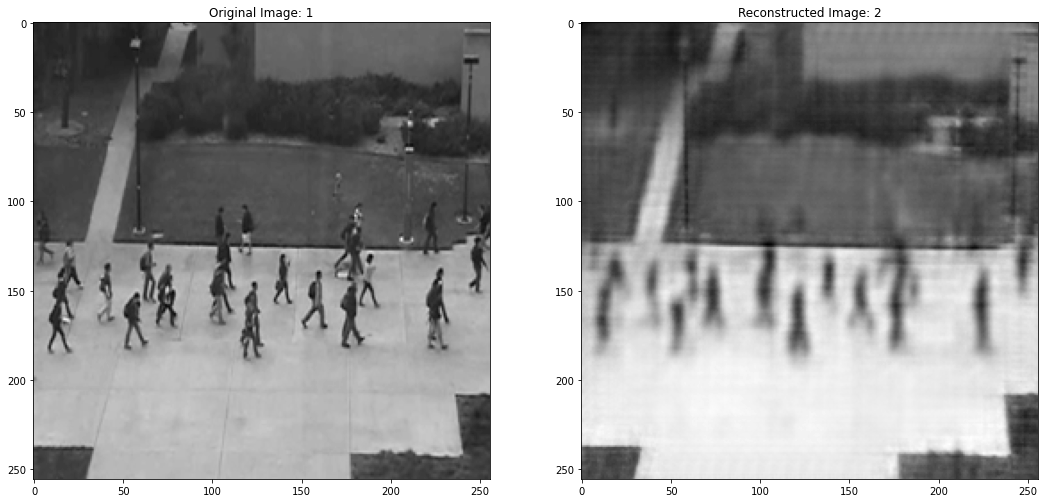

10/16 [=================>............] - ETA: 3:37 - rec: 0.0012
Epoch: 1, Batch_number: 10


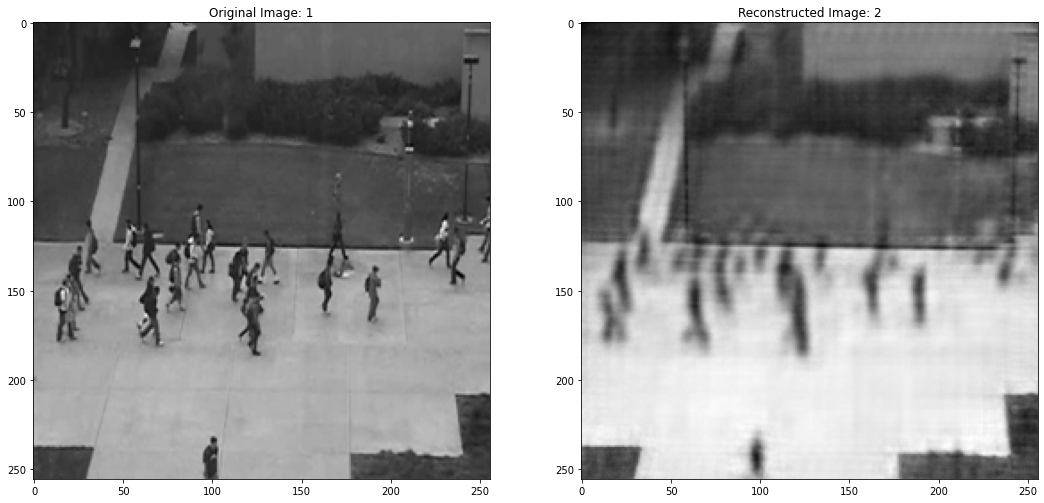

16/16 [==============================] - 568s 36s/step - rec: 0.0012

(^|^)  ('|')
0 [0.001187 is reconstruction loss]
Epoch :  2
Epoch: 2, Batch_number: 0


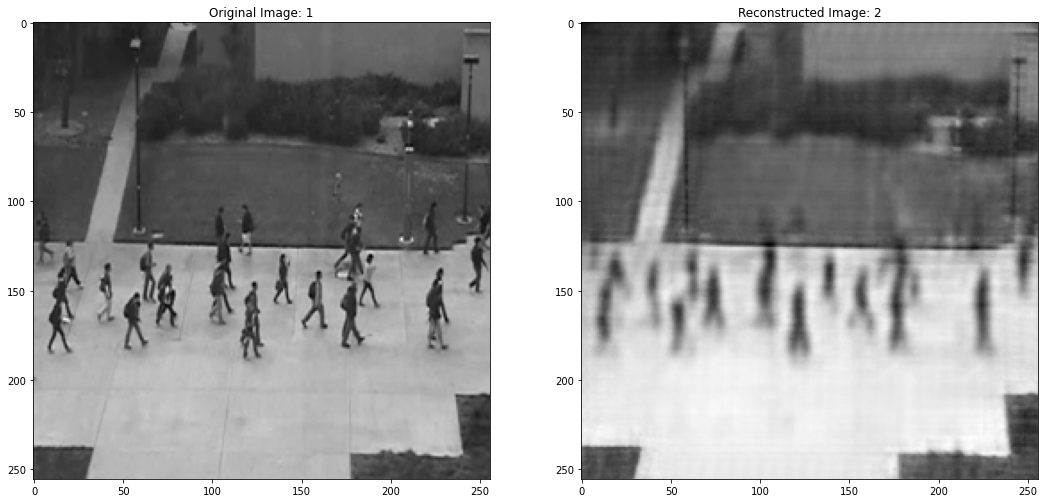

 6/16 [==========>...................] - ETA: 5:29 - rec: 0.0011


In [ ]:
auto_encoder_model.train_gan(train_gen)


In [1]:
def get_single_test(test_file_path):
    segments = []
    frames = []
    num_segments = 0
    for c in sorted(listdir(test_file_path)):
        img_path = join(test_file_path, c).replace("\\", '/')
        if str(img_path)[-3:] == "tif":
            img = Image.open(img_path).resize((ModelConfig.H, ModelConfig.W))
            img = np.array(img, dtype=np.float32) / 255.0
            frames.append(img)
            if len(frames) == ModelConfig.SEQUENCE_SIZE:
              segments.append(save_samples_npz(frames, ModelConfig.TEST_SAMPLE_NPZ_DIRECTORY, num_segments))
              num_segments += 1
              frames.clear()
    return segments

In [2]:
segments_frames_list = get_single_test(ModelConfig.SINGLE_TEST_PATH)

NameError: ignored

In [143]:
import matplotlib.pyplot as plt

def evaluate(model, segments_frames_list):    
    segments_len = len(segments_frames_list)
    sz = 0
    num_segments = 0
    sequences = []
    reconstructed_sequences = []
    sample_reconstruction_cost = []
    while sz < segments_len:
        minibatch = np.array([load_npz_4D_sample(ModelConfig.TEST_SAMPLE_NPZ_DIRECTORY,
                                                 segments_frames_list[sz])])
        minibatch = minibatch.reshape((-1, ModelConfig.SEQUENCE_SIZE, ModelConfig.H, ModelConfig.W, ModelConfig.C))
        X = np.transpose(minibatch, (0,2,3,1,4))
        reconstructed = model.predict(X)
        reconstructed = np.transpose(reconstructed, (0,3,1,2,4))
        sz+=1

        for index in range(len(minibatch)):
          sequences.extend(minibatch[index])
          reconstructed_sequences.extend(reconstructed[index])
          org_frame = minibatch[index]
          rec_frame = reconstructed[index]
          diff = [np.linalg.norm(np.subtract(org_frame[i], rec_frame[i])) for i in range(0,len(org_frame))]
          sample_reconstruction_cost.extend(diff)
    

    sample_reconstruction_cost = np.array(sample_reconstruction_cost)
    sa = (sample_reconstruction_cost - np.min(sample_reconstruction_cost)) / np.max(sample_reconstruction_cost)    
    sr = 1.0 - sa
    sequences = np.array(sequences)
    reconstructed_sequences = np.array(reconstructed_sequences)
    
    return sequences, reconstructed_sequences, sr

In [144]:
segments_frames_list = get_single_test(ModelConfig.SINGLE_TEST_PATH)


In [145]:
sequences, reconstructed_sequences, sr = evaluate(auto_encoder_model.autoencoder, 
                                                  segments_frames_list)
sr

array([0.96012866, 0.9774595 , 0.9723162 , 0.96351445, 0.9544531 ,
       0.9545925 , 0.9513607 , 0.95463645, 0.95776206, 0.9232912 ,
       0.9178985 , 0.9578358 , 0.95974183, 0.96763223, 0.96919537,
       0.9770286 , 0.97883207, 0.9756795 , 0.9688678 , 0.9472331 ,
       0.94357216, 0.97322613, 0.9695134 , 0.9630369 , 0.9533247 ,
       0.9500017 , 0.94266915, 0.9406908 , 0.94331247, 0.9109748 ,
       0.90617216, 0.9455089 , 0.9477306 , 0.95159423, 0.96435547,
       0.9725954 , 0.96903247, 0.96071076, 0.95598716, 0.93037343,
       0.9258064 , 0.9585563 , 0.9641448 , 0.9598143 , 0.95522374,
       0.95361793, 0.94996464, 0.944607  , 0.93452704, 0.8987573 ,
       0.88971686, 0.91989785, 0.921561  , 0.9247904 , 0.93499357,
       0.9399096 , 0.94181824, 0.9475528 , 0.9436951 , 0.9123659 ,
       0.8967881 , 0.9243296 , 0.9219177 , 0.9134763 , 0.90095705,
       0.89962053, 0.9030585 , 0.9044611 , 0.90058684, 0.8776485 ,
       0.87691206, 0.91672635, 0.9138216 , 0.92340654, 0.92256

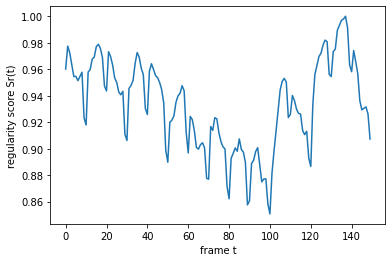

In [146]:
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [147]:
sequences.shape

(150, 256, 256, 1)

In [148]:
seq_num = 100

In [149]:
result = []
result.append(sequences[seq_num].reshape((ModelConfig.H, ModelConfig.W)))
result.append(reconstructed_sequences[seq_num].reshape((ModelConfig.H, ModelConfig.W)))
result = np.array(result)

In [150]:
result.shape


(2, 256, 256)

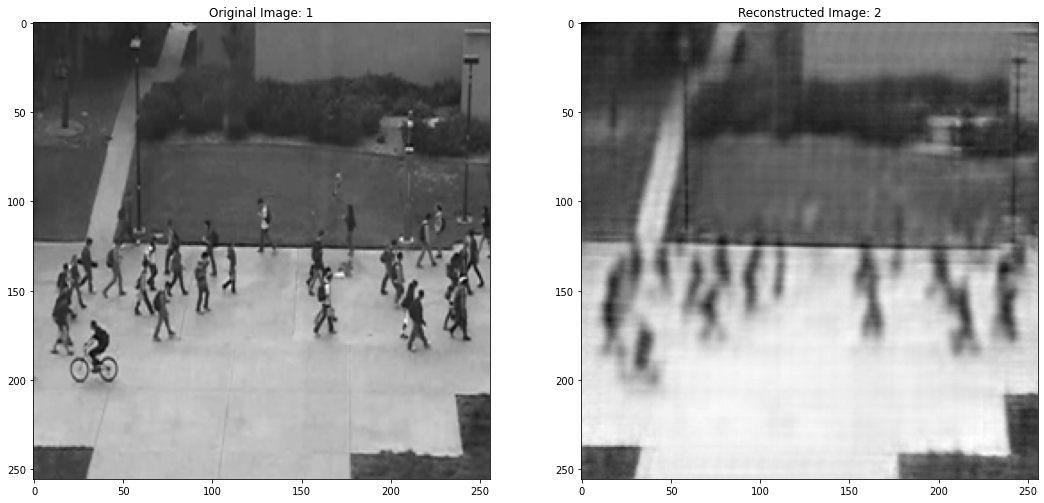

In [151]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(result[i], cmap="gray")
    if i % 2 == 0:
      plt.title('Original Image: {}'.format(i+1))
    else:
      plt.title('Reconstructed Image: {}'.format(i+1))

plt.show()

In [152]:
from scipy import signal
from PIL import Image

In [153]:
def fig2data(fig):
    fig.canvas.draw ( )
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    data = data.reshape((h, w, 3))
    return data

In [154]:
def plot(img, fig, axes,output, diff, H, threshold):
    (ax0, ax1, ax2,ax3) = axes
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    data = fig2data ( fig )
    return Image.fromarray(data)

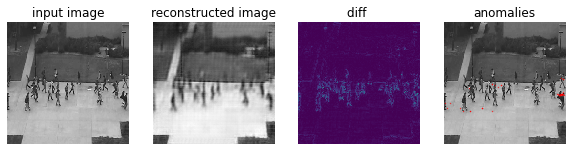

In [155]:
threshold = 3*255
counter = 0

fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
frame_result = [] 

i = 0
for seq, rec_seq in zip(sequences, reconstructed_sequences):
    counter = counter + 1
    img = seq*255
    output = rec_seq*255
    diff = np.abs(output-img)

    tmp = diff[:,:,0]
    H = signal.convolve2d(tmp, np.ones((3,3)), mode='same')

    res = plot(img[:,:,0], fig, (ax0, ax1, ax2,ax3), output[:,:,0], diff[:,:,0],
               H, threshold)
    
    frame_result.append(res)


In [156]:
frame_result[0].save("frames_result.gif", save_all=True, 
                      append_images=frame_result[1:], duration=100, loop=0)

In [139]:
auto_encoder_model.autoencoder.save_weights(join(ModelConfig.MODEL_WEIGHTS_DIRECTORY, ModelConfig.AUTOENCODER_MODEL_PATH))